## OSCAR JULIÁN PERDOMO CHARRY, PhD, ojperdomoc@unal.edu.co
## SISTEMAS EMBEBIDOS
## UNIVERSIDAD NACIONAL DE COLOMBIA

# Uso de Decision Trees and Random Forests para "HAR" usando acelerómetros!

# Consideraciones iniciales de la base de datos

*We will be analyzing the data with respect to all the subjects as we want to classify the activities in general and not be specific to the person.*

*The modelling for the data will be with respect to the sliding window functionality as the data samples are already sampled with 1 second window with 50% overlap.
This approach will take into consideration the pre-activities that will be involved in the actions being taken by the person as a sequence and will help in making better recurrent neural networks models.*

*'Working at Computer', 'Standing Up, Walking and Going up\\down stairs', 'Standing', 'Walking', 'Going Up\\Down Stairs', 'Walking and Talking with Someone', 'Talking while Standing'*



## Cargando y entendiendo los datos

In [11]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
#plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.ensemble as ske
import sklearn.tree as skt
import sklearn.preprocessing as skp
import random
import os, shutil, re, string
import spacy
seed=100

In [12]:
from google.colab import drive
#drive.mount('/gdrive/')
# Si colocan algun archivo nuevo
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [13]:
!ls "/content/gdrive/MyDrive/Cursos_2025-2/Sistemas Embebidos/Clase18_23 de Octubre de 2025/"

 0_Human_Activity_Recognition.ipynb
 1_RedesNeuronales_I.ipynb
'Activity Recognition from Single Chest-Mounted Accelerometer'
 dataset_acc.csv
 s41598-020-79217-x.pdf


In [14]:
# DEBEN COLOCAR SU PATH HACIA LA CARPETA QUE CONTIENE LOS DATOS
!ls '/content/gdrive/MyDrive/Cursos_2025-2/Sistemas Embebidos/Clase18_23 de Octubre de 2025/Activity Recognition from Single Chest-Mounted Accelerometer/'

10.csv	12.csv	14.csv	1.csv  3.csv  5.csv  7.csv  9.csv
11.csv	13.csv	15.csv	2.csv  4.csv  6.csv  8.csv  README


In [15]:
# CARGANDO LOS DATOS DESDE GOOGLE-DRIVE
# scanning data and merging with participant as person column for identification
DIR = '/content/gdrive/MyDrive/Cursos_2025-2/Sistemas Embebidos/Clase18_23 de Octubre de 2025/Activity Recognition from Single Chest-Mounted Accelerometer/'
df = pd.DataFrame()
for x in range(1,16):
    df_temp = pd.read_csv(os.path.join(DIR, str(x)+'.csv'))
    df_temp.columns = ['index','x','y','z','class']
    df_temp['person'] = x
    df_temp.drop('index', inplace=True, axis=1)
#     df_temp.drop(df_temp[df_temp['class'] == 0].index.tolist(), inplace=True, axis=0)
    df = pd.concat([df, df_temp], axis=0)

df = df.reset_index(drop=True)
print("Scanned",len(df.person.unique()),"participants recordings")
df.tail()

Scanned 15 participants recordings


,x,y,z,class,person
1926876,2043,2539,1990,7,15
1926877,2036,2508,1976,7,15
1926878,2025,2520,1991,7,15
1926879,2009,2546,2007,7,15
1926880,1999,2532,1996,0,15


In [16]:
!ls '/content/gdrive/MyDrive/Cursos_2025-2/Sistemas Embebidos/Clase18_23 de Octubre de 2025/'

 0_Human_Activity_Recognition.ipynb
 1_RedesNeuronales_I.ipynb
'Activity Recognition from Single Chest-Mounted Accelerometer'
 dataset_acc.csv
 s41598-020-79217-x.pdf


In [17]:
df.shape

(1926881, 5)

In [18]:
df.head()

,x,y,z,class,person
0,1667,2072,2047,1,1
1,1611,1957,1906,1,1
2,1601,1939,1831,1,1
3,1643,1965,1879,1,1
4,1604,1959,1921,1,1


In [19]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/Cursos_2025-2/Sistemas Embebidos/Clase18_23 de Octubre de 2025/dataset_acc.csv')
#df = pd.read_csv('/content/dataset_acc.csv')
df.shape

(1926881, 6)

In [20]:
df.head()

,Unnamed: 0,x,y,z,class,person
0,0,1667,2072,2047,1,1
1,1,1611,1957,1906,1,1
2,2,1601,1939,1831,1,1
3,3,1643,1965,1879,1,1
4,4,1604,1959,1921,1,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926881 entries, 0 to 1926880
Data columns (total 6 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   x           int64
 2   y           int64
 3   z           int64
 4   class       int64
 5   person      int64
dtypes: int64(6)
memory usage: 88.2 MB


In [22]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [23]:
df.head()

,x,y,z,class,person
0,1667,2072,2047,1,1
1,1611,1957,1906,1,1
2,1601,1939,1831,1,1
3,1643,1965,1879,1,1
4,1604,1959,1921,1,1


In [24]:
#df.to_csv('dataset_acc.csv')

In [25]:
# map index to label
index_label = dict()
index_label[0] = "None"
index_label[1] = "Working at Computer"
index_label[2] = "Standing Up, Walking and Going up\down stairs"
index_label[3] = "Standing"
index_label[4] = "Walking"
index_label[5] = "Going Up\Down Stairs"
index_label[6] = "Walking and Talking with Someone"
index_label[7] = "Talking while Standing"

index_label.values()

dict_values(['None', 'Working at Computer', 'Standing Up, Walking and Going up\\down stairs', 'Standing', 'Walking', 'Going Up\\Down Stairs', 'Walking and Talking with Someone', 'Talking while Standing'])

## Visualización de Datos Inicial

In [ ]:
df.tail()

,x,y,z,class,person
1926876,2043,2539,1990,7,15
1926877,2036,2508,1976,7,15
1926878,2025,2520,1991,7,15
1926879,2009,2546,2007,7,15
1926880,1999,2532,1996,0,15


In [ ]:
df['class'].value_counts().reset_index()

,class,count
0,1,608652
1,7,593563
2,4,357064
3,3,216737
4,5,51498
5,2,47878
6,6,47770
7,0,3719


In [ ]:
df[df['person']==1]

,x,y,z,class,person
0,1667,2072,2047,1,1
1,1611,1957,1906,1,1
2,1601,1939,1831,1,1
3,1643,1965,1879,1,1
4,1604,1959,1921,1,1
...,...,...,...,...,...
162495,1927,2388,2074,7,1
162496,1930,2383,2074,7,1
162497,1929,2385,2076,7,1
162498,1926,2385,2078,7,1


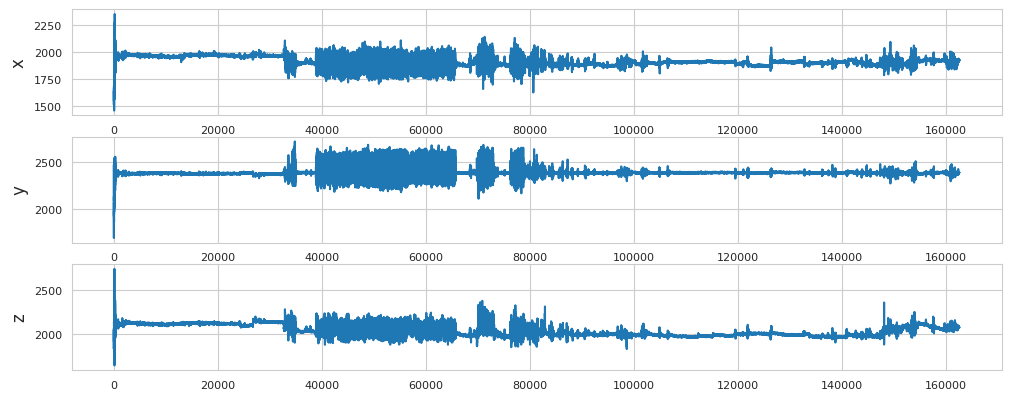

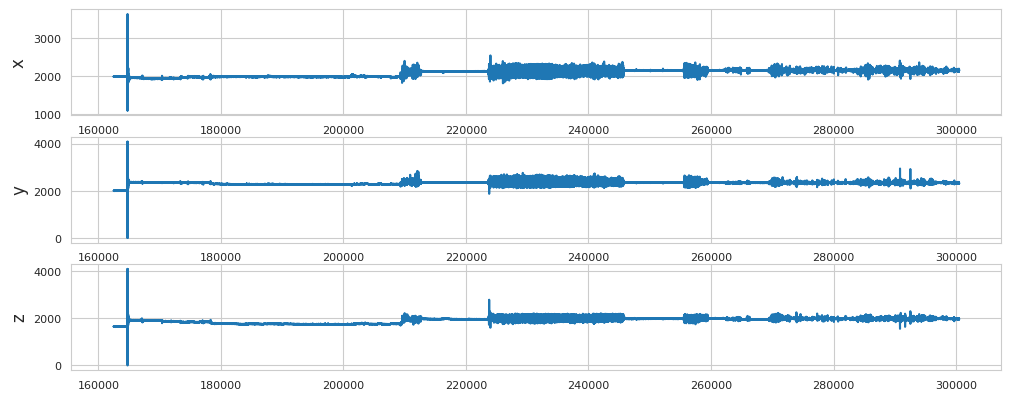

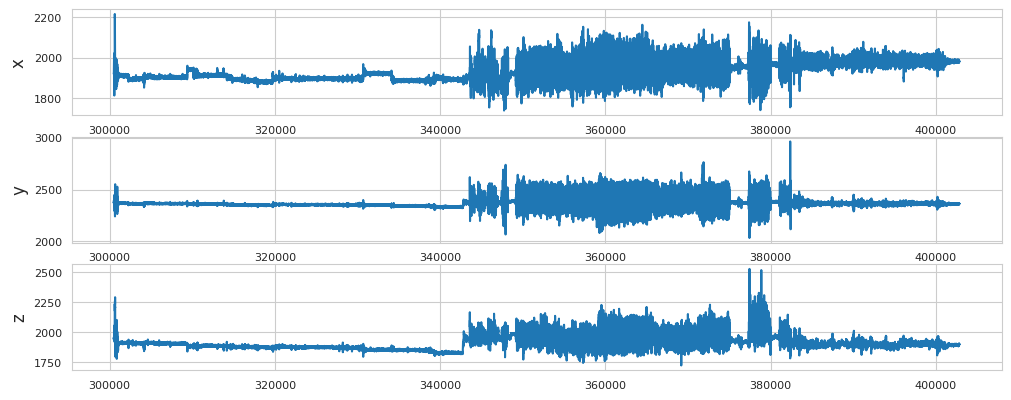

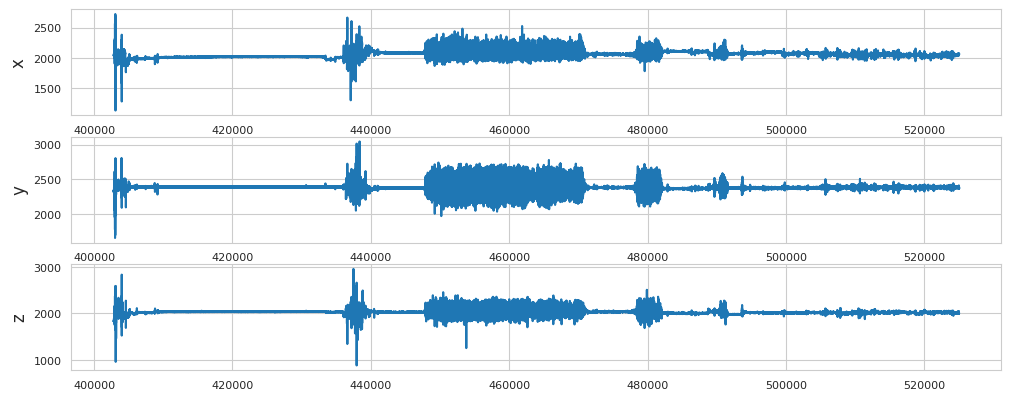

In [ ]:
# plot x, y, z acceleration
def plotXYZ(df_plot, p):
    plt.figure()
    for col in range(3):
        plt.subplot(df_plot.shape[1], 1, col+1)
        sns.lineplot(data=df_plot,x=np.array(df_plot.index.tolist()), y=df_plot.iloc[:,col])
    plt.show()

for x in range(1,5):
    df_temp = df[df["person"]==x]
    plotXYZ(df_temp, x)

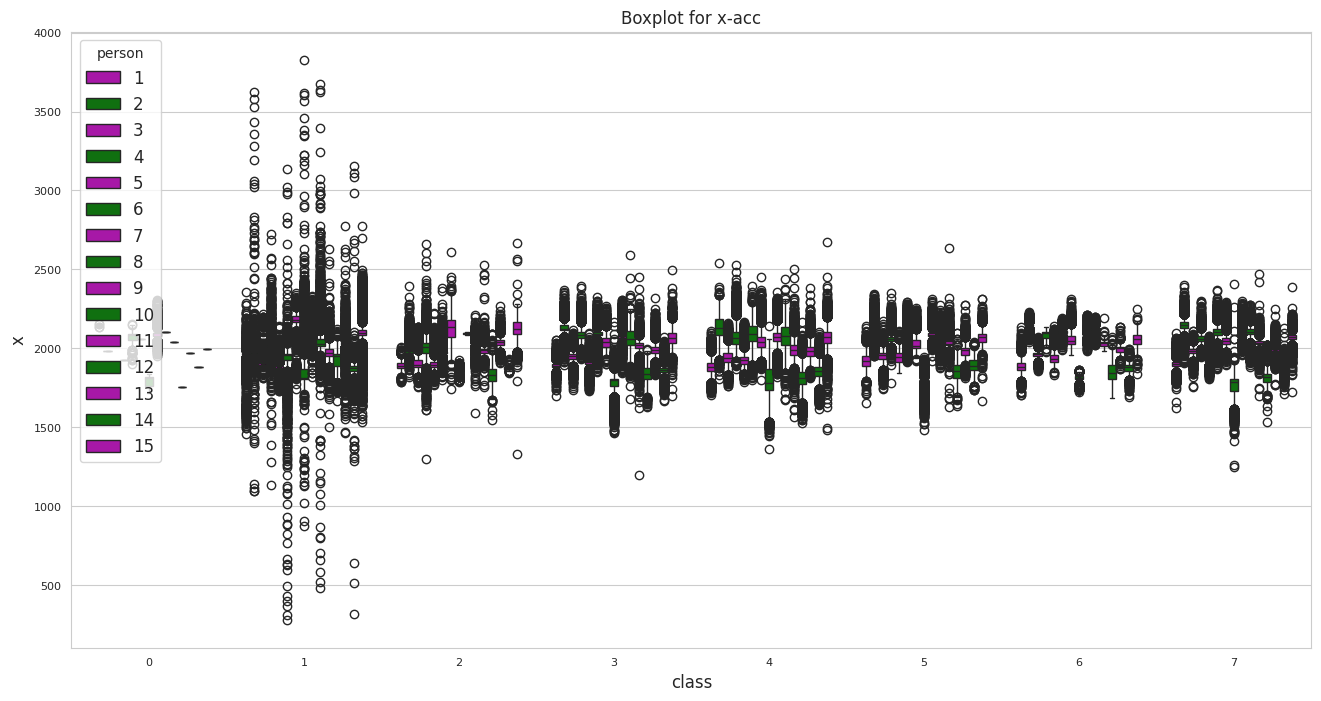

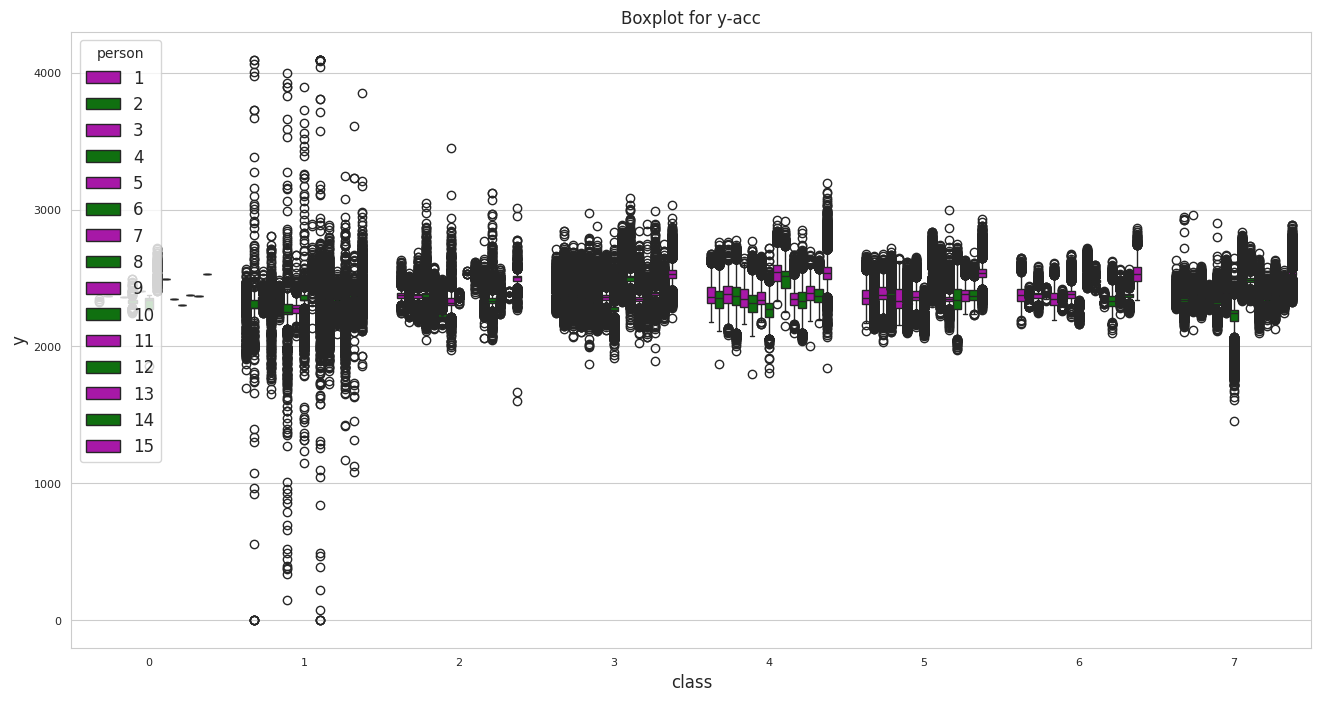

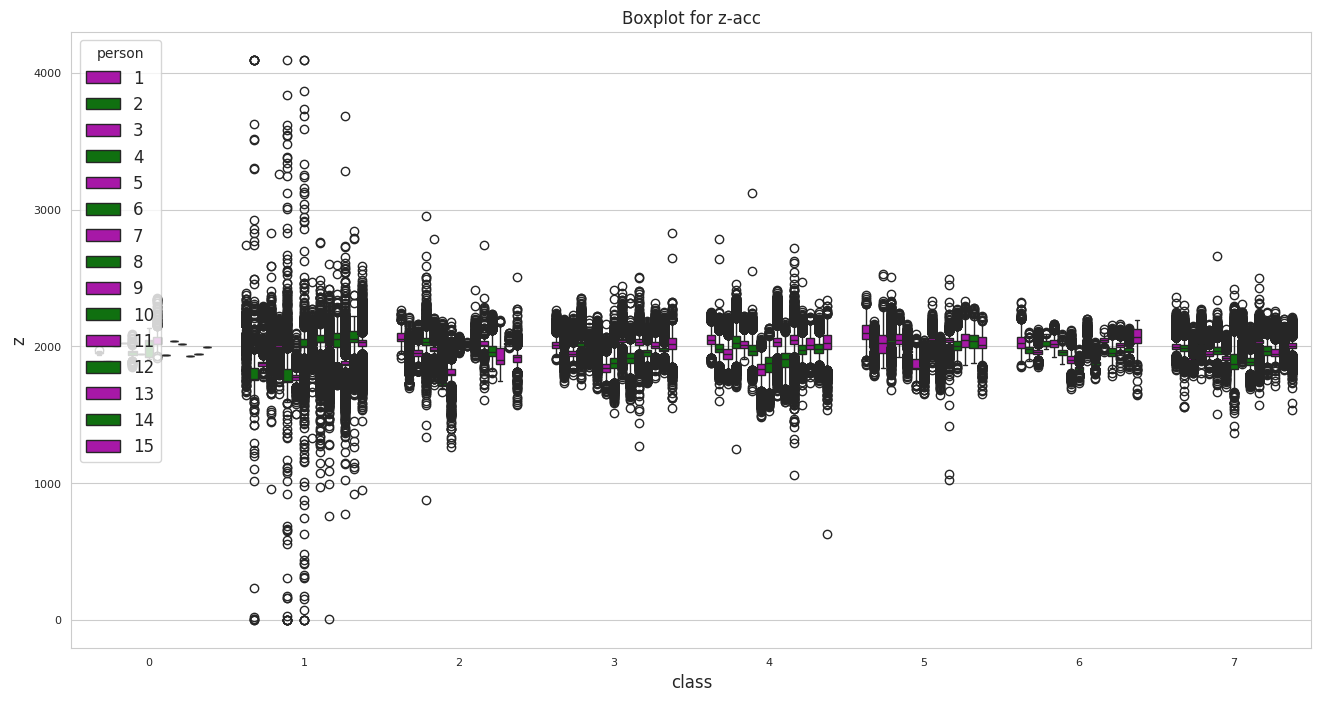

In [ ]:
# plot boxplot for all classes
plt.figure(figsize=(16,8))
sns.boxplot(x="class", y="x",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for x-acc")
plt.show()


plt.figure(figsize=(16,8))
sns.boxplot(x="class", y="y",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for y-acc")
plt.show()


plt.figure(figsize=(16,8))
sns.boxplot(x="class", y="z",
            hue="person", palette=["m", "g"],
            data=df)
plt.title("Boxplot for z-acc")
plt.show()


There are outliers present in the data. Class 1 has most number of outliers present in it and need to be treated.

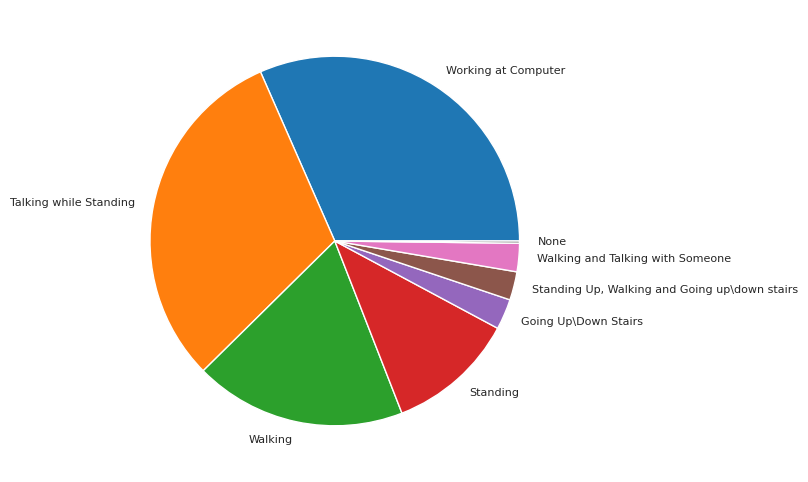

In [ ]:
# checking distribution of samples against classes
plt.figure(figsize=(12,6))
plt.pie(df['class'].value_counts(), labels=[index_label[x] for x in df['class'].value_counts().index])
plt.show()

*   index_label[1] = "Working at Computer",
*   index_label[3] = "Standing",
*   index_label[4] = "Walking",
*   index_label[7] = "Talking while Standing"

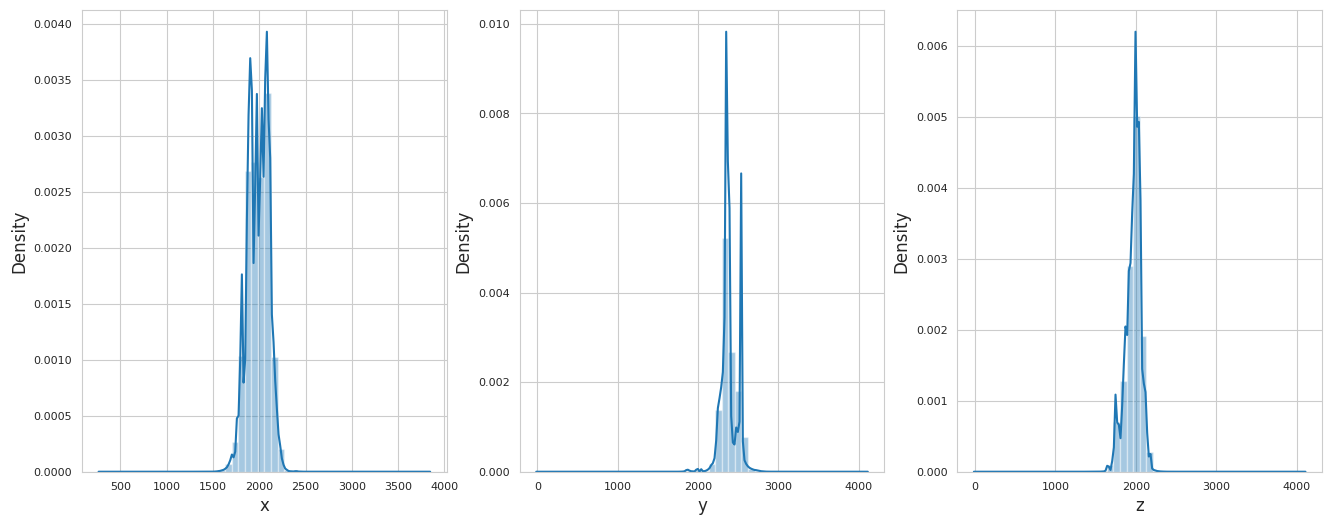

In [ ]:
# checking distributions for x, y and z
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.distplot(df['x'])

plt.subplot(1,3,2)
sns.distplot(df['y'])

plt.subplot(1,3,3)
sns.distplot(df['z'])
plt.show()

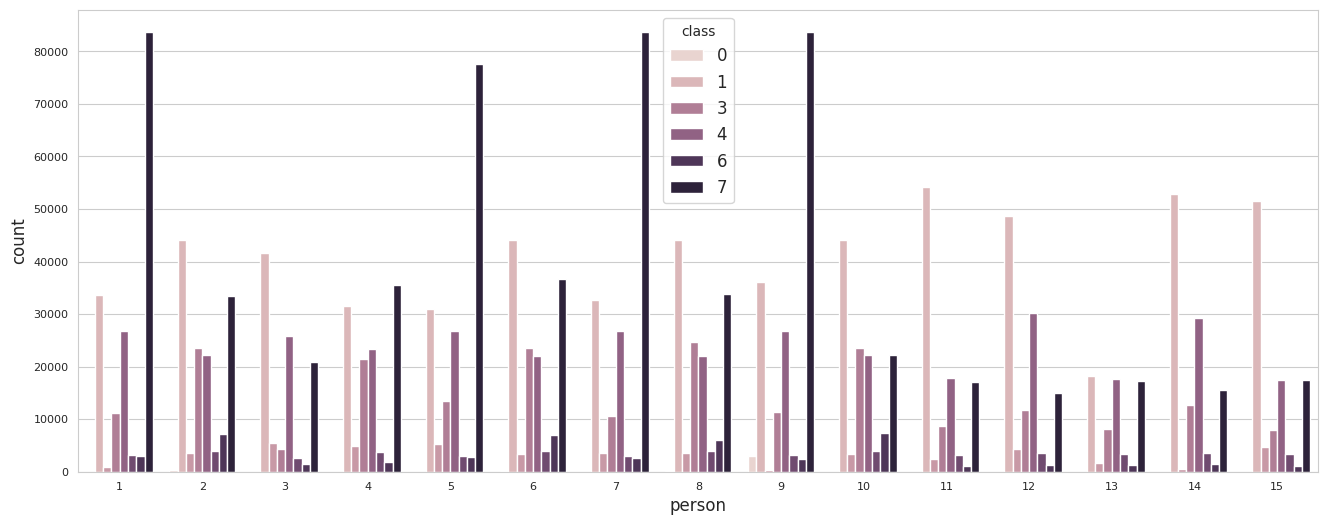

In [ ]:
# countplot distribution for each person per class
plt.figure(figsize=(16,6))
sns.countplot(x='person', hue='class', data=df)
plt.show()

## **Como conclusión encontramos que las clases estan altamente imbalanceadas y necesitan ser analizadas con cuidado!!!**

# Data Preparation

In [26]:
# remove multi-activities classes - 0, 2, and 6
df = df[~df["class"].isin([0,2,5,6,3])]
print("Remaining classes",df['class'].unique())

Remaining classes [1 4 7]


In [27]:
# replacing class 0, and 2 with 5 and 7 respectively.
# 0 => 5
# 2 => 7
df['class'] = [2 if x is 7 else x for x in df['class']]
df['class'] = [3 if x is 4 else x for x in df['class']]
df['class'].value_counts().reset_index()

,class,count
0,1,608652
1,2,593563
2,3,357064


In [28]:
# removing outliers, values away from mean +- x*sd, from all classes for x, y and z
indexesToRemove = []
for x in df['class'].unique().tolist():
    # filter with specific class
    print("Filtering class",x)
    df_temp = df[df['class'] == x]

    for y in range(3):
        # remove rows with values away from mean by 3SD, in x, y and z
        mean = df_temp.iloc[:,y].mean()
        sd = df_temp.iloc[:,y].std()
        away = 3
        upperlimit = mean + away * sd
        lowerlimit = mean - away * sd

        i = df_temp[(df_temp.iloc[:,y] > upperlimit) | (df_temp.iloc[:,y] < lowerlimit)].index.tolist()
        indexesToRemove.extend(i)

indexesToRemove = list(set(indexesToRemove))
df.drop(indexesToRemove, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Removed",len(indexesToRemove),"rows.")

Filtering class 1
Filtering class 3
Filtering class 2
Removed 22157 rows.


In [19]:
# checking distribution of x, y and z after removing outliers
df.describe()

,x,y,z,class,person
count,1537122.00,1537122.00,1537122.00,1537122.00,1537122.00
mean,1986.43,2386.40,1973.15,1.84,7.52
std,106.11,91.69,93.15,0.77,4.22
min,1605.00,2042.00,1596.00,1.00,1.00
25%,1905.00,2340.00,1919.00,1.00,4.00
50%,1983.00,2369.00,1993.00,2.00,7.00
75%,2071.00,2413.00,2035.00,2.00,11.00
max,2348.00,2731.00,2337.00,3.00,15.00


## Creando los conjuntos de Entrenamiento y Prueba

In [29]:
# splitting by person recordings, first 12 for training and last 3 for test
X_train = df[df['person'] <= 12]
X_test = df[df['person'] > 12]
y_train = X_train.pop('class')
y_test = X_test.pop('class')
X_train.head()

,x,y,z,person
0,1726,2203,2005,1
1,1778,2143,1946,1
2,1718,2102,2012,1
3,1724,2101,2309,1
4,1706,2277,1986,1


In [30]:
# drop person column from both
X_train.drop('person', axis=1, inplace=True)
X_test.drop('person', axis=1, inplace=True)
X_train.head()

,x,y,z
0,1726,2203,2005
1,1778,2143,1946
2,1718,2102,2012
3,1724,2101,2309
4,1706,2277,1986


In [34]:
y_train.sample(10)

,class
366818,3
631459,2
734446,2
612459,3
880706,2
800085,1
1104639,2
656547,1
1234150,1
249613,1


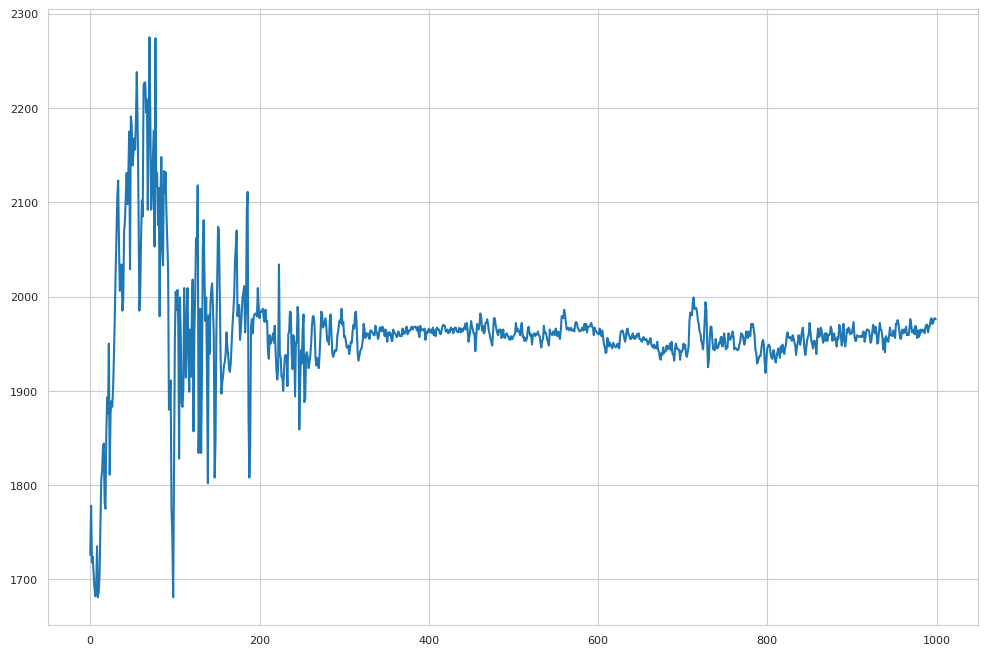

In [22]:
plt.plot(X_train['x'][0:1000])

In [ ]:
X_train['x'].max()

2348

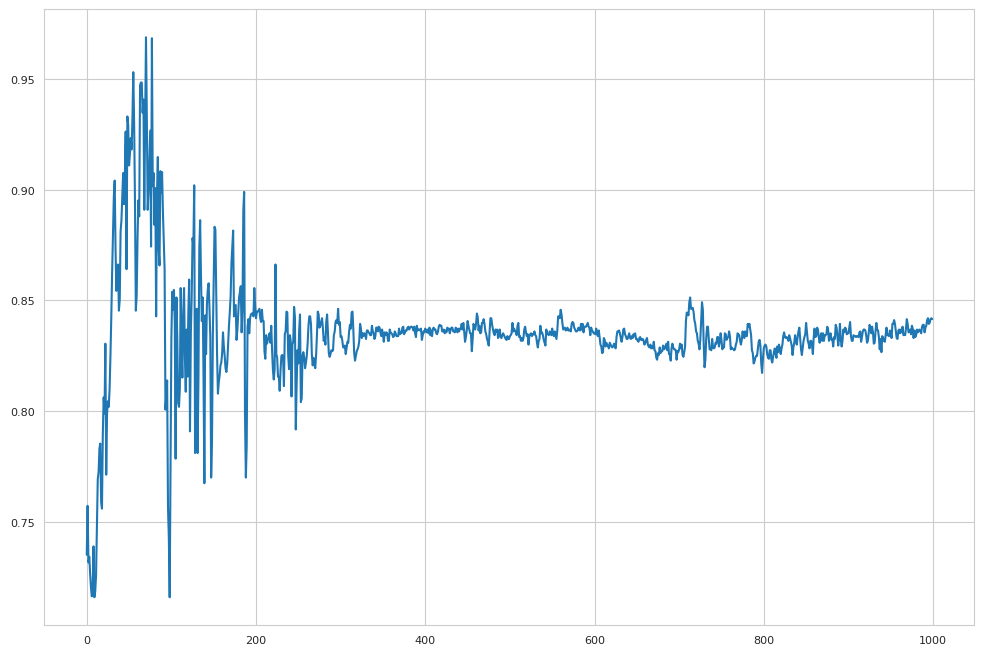

In [ ]:
plt.plot(X_train['x'][0:1000]/X_train['x'].max())

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((1301690, 3), (1301690,), (235432, 3), (235432,))

## Colocando pesos para mitigar el "Class Imbalance"

In [23]:
# generate training class weights which will be fed into model while training
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
train_class_weights = dict(zip(np.unique(y_train), weights))
pprint(train_class_weights)

{np.int64(1): np.float64(0.905917985849838),
 np.int64(2): np.float64(0.8115329967973596),
 np.int64(3): np.float64(1.5062247817941767)}


## Escalando los Datos

In [24]:
scaler = skp.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

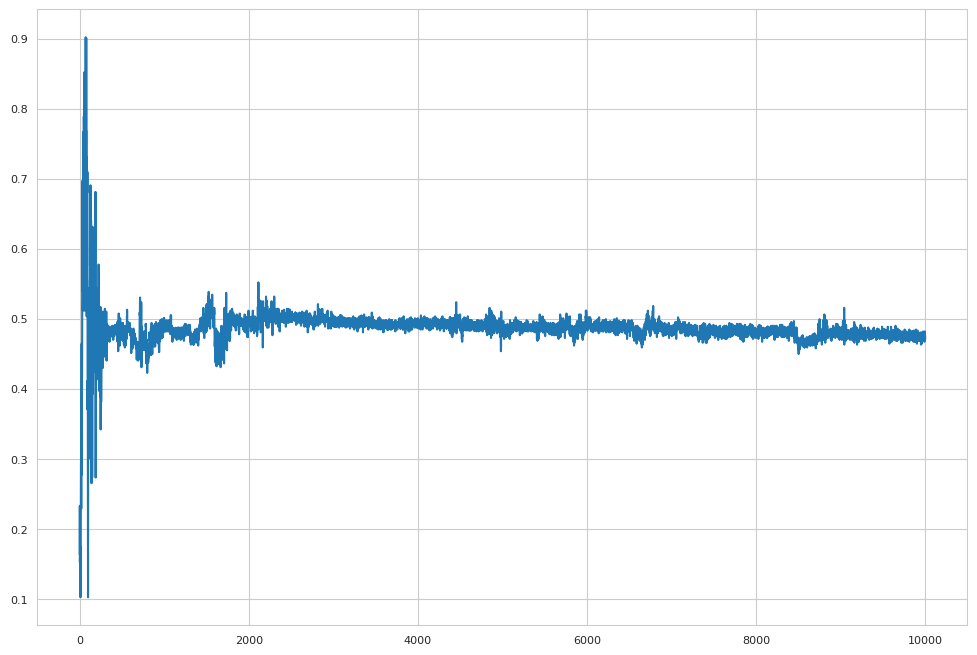

In [25]:
plt.plot(X_train['x'][0:10000])

## Decision Tree Model

In [36]:
dtc = skt.DecisionTreeClassifier(max_depth=8, random_state=seed, class_weight=train_class_weights)
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
skm.accuracy_score(y_test, predictions)

0.49425736518400215

In [32]:
from sklearn.metrics import confusion_matrix
predictions_tr = dtc.predict(X_train)
confusion_matrix(y_train, predictions_tr)

array([[397349,  65279,  16330],
       [212057, 282682,  39924],
       [ 95281,  94429,  98359]])

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[58717, 62659,   629],
       [32323, 16945,   385],
       [36435, 15832, 11507]])

In [37]:
import pickle
#import joblib
filename = 'DT_model3.sav'
pickle.dump(dtc, open(filename, 'wb'))
#joblib.dump(model, filename)

In [38]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.49425736518400215

## Random Forest Model

In [54]:
rfc = ske.RandomForestClassifier(n_estimators=3, random_state=seed, class_weight=train_class_weights)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
skm.accuracy_score(y_test, predictions)

0.4412654184647796

In [55]:
from sklearn.metrics import confusion_matrix
predictions_tr = rfc.predict(X_train)
confusion_matrix(y_train, predictions_tr)

array([[470043,   4968,   3947],
       [  6807, 517427,  10429],
       [  5720,  11224, 271125]])

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[40243, 47843, 33919],
       [12411, 21212, 16030],
       [10405, 10936, 42433]])

In [57]:
import pickle
#import joblib
filename = 'RF_model3.sav'
pickle.dump(rfc, open(filename, 'wb'))
#joblib.dump(model, filename)

In [58]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.4412654184647796

In [59]:
!pip list -v

Package                                  Version             Location                                Installer
---------------------------------------- ------------------- --------------------------------------- ---------
absl-py                                  1.4.0               /usr/local/lib/python3.12/dist-packages uv
absolufy-imports                         0.3.1               /usr/local/lib/python3.12/dist-packages uv
accelerate                               1.11.0              /usr/local/lib/python3.12/dist-packages uv
aiofiles                                 24.1.0              /usr/local/lib/python3.12/dist-packages uv
aiohappyeyeballs                         2.6.1               /usr/local/lib/python3.12/dist-packages uv
aiohttp                                  3.13.1              /usr/local/lib/python3.12/dist-packages uv
aiosignal                                1.4.0               /usr/local/lib/python3.12/dist-packages uv
alabaster                                1.0.0    

## **Hacer un Pipeline para dejar todo en un solo paso!**
[Como hacer pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
# Coloque su código acá!
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train, y_train).score(X_test, y_test)

0.88

In [ ]:
import pickle
#import joblib
filename = 'finalized_model.sav'
pickle.dump(pipe, open(filename, 'wb'))
#joblib.dump(model, filename)

In [ ]:
pipe.fit(X_train, y_train).predict(X_test)

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0])

In [ ]:
pipe.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)

0.76

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.88

#**Muchas gracias a todos por su atención!!!**

![alt text](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/rick-and-morty-season-5-episode-8-3-1628498167.jpg?crop=0.5625xw:1xh;center,top&resize=768:*)



![](https://i.imgur.com/oNWO8.png)

# Actividad práctica
### 1. Crear una base de datos que use Acelerómetros/Giroscopios.
### 2. Entrenar un Decision Tree, un Random Forest y una red neuronal en Google Colab. POR FAVOR, NO REALIZAR ESTO EN LA RASPBERRY PI.
### 3. Exporte el modelo de Colab (Use pickle o joblib) y carguelo en la Raspberry Pi.
### 4. Implemente el circuito y haga funcionar en tiempo real los tres clasificadores de forma individual donde se emplean diodos LEDs para visualizar las salidas (targets).
### 5. Finalmente, limite su problema a un problema binario. Obtenga el grafo en Colab (árbol de decisión) y siga este ejemplo en el papel o Colab para [transformar un DecisionTree en operaciones matriciales](https://blog.dailydoseofds.com/p/transform-decision-tree-into-matrix), para posteriormente realizar el computo en la raspberry Pi.

In [1]:
!pip install joblib==1.5.0

In [2]:
!pip list -v

Package                                  Version             Location                                Installer
---------------------------------------- ------------------- --------------------------------------- ---------
absl-py                                  1.4.0               /usr/local/lib/python3.12/dist-packages uv
absolufy-imports                         0.3.1               /usr/local/lib/python3.12/dist-packages uv
accelerate                               1.11.0              /usr/local/lib/python3.12/dist-packages uv
aiofiles                                 24.1.0              /usr/local/lib/python3.12/dist-packages uv
aiohappyeyeballs                         2.6.1               /usr/local/lib/python3.12/dist-packages uv
aiohttp                                  3.13.1              /usr/local/lib/python3.12/dist-packages uv
aiosignal                                1.4.0               /usr/local/lib/python3.12/dist-packages uv
alabaster                                1.0.0    

In [8]:
import pickle
pickle.compatible_formats

['1.0', '1.1', '1.2', '1.3', '2.0', '3.0', '4.0', '5.0']